# **1. Introdução**
A Multiplus enfrenta desafios na gestão logística devido à alta rotatividade de analistas. Este notebook propõe uma solução baseada em IA para:
- Automatizar roteirização dinâmica
- Prever desempenho de motoristas e veículos
- Integrar dados de telemetria (ISAT) e combustível
- Gerar dashboards operacionais


---


**Tecnologias usadas:**

>- Python (linguagem base)
- Pandas e NumPy – manipulação e simulação de dados
- Scikit-learn – modelagem preditiva (Random Forest)
- Google OR-Tools – roteirização dinâmica
- Plotly Express – visualizações interativas

# **2. Diagnóstico do Problema**

### Principais Dores

| Problema                 | Impacto                              |
|--------------------------|------------------------------------|
| Rotatividade de analistas | Descontinuidade operacional       |
| Roteirização manual      | Ineficiência e atrasos            |
| Falta de previsão de riscos | Custos elevados com combustível e multas |

### Dados Disponíveis

| Fonte                  | Dados                                |
|------------------------|------------------------------------|
| ISAT                   | Localização GPS, velocidade, paradas |
| Sistema de Combustível | Abastecimento, consumo por veículo |
| ERP                    | Pedidos, janelas de entrega       |


# **3. Solução Proposta**
**Arquitetura do Sistema**

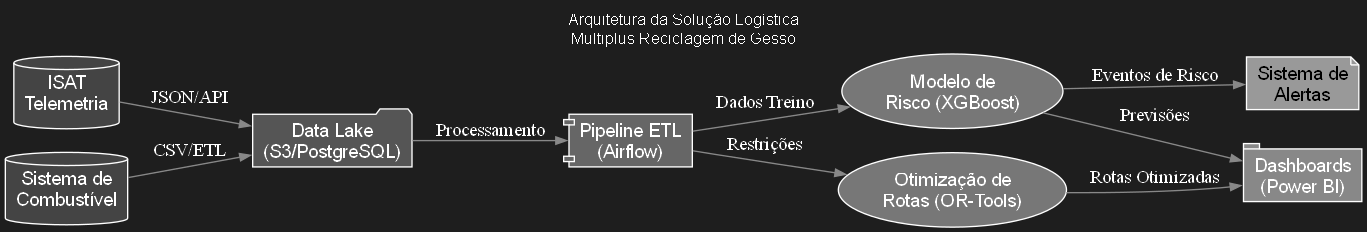

In [2]:
!pip install graphviz

import graphviz
from graphviz import Digraph
from IPython.display import Image, display


def criar_diagrama_arquitetura():
    dot = Digraph(
        comment="Arquitetura da Solução Multiplus",
        format="png",
        graph_attr={
            "rankdir": "LR",
            "bgcolor": "#1e1e1e",
            "fontname": "Arial",
            "fontsize": "12",
            "label": "Arquitetura da Solução Logística\nMultiplus Reciclagem de Gesso",
            "labelloc": "t",
            "fontcolor": "white"
        },
        node_attr={
            "shape": "box",
            "style": "rounded,filled",
            "fontname": "Arial",
            "color": "#ffffff",
            "fillcolor": "#252525",
            "fontcolor": "#ffffff"
        },
        edge_attr={
            "color": "#888888",
            "arrowsize": "0.8",
            "fontcolor": "white"
        }
    )

    # Definição de nós
    dot.node("ISAT", "ISAT\nTelemetria", shape="cylinder", fillcolor="#444444", fontcolor="white")
    dot.node("COMB", "Sistema de\nCombustível", shape="cylinder", fillcolor="#444444", fontcolor="white")
    dot.node("DATA", "Data Lake\n(S3/PostgreSQL)", shape="folder", fillcolor="#555555", fontcolor="white")
    dot.node("ETL", "Pipeline ETL\n(Airflow)", shape="component", fillcolor="#666666", fontcolor="white")
    dot.node("ML", "Modelo de\nRisco (XGBoost)", shape="ellipse", fillcolor="#777777", fontcolor="white")
    dot.node("ROTA", "Otimização de\nRotas (OR-Tools)", shape="ellipse", fillcolor="#777777", fontcolor="white")
    dot.node("DASH", "Dashboards\n(Power BI)", shape="tab", fillcolor="#888888", fontcolor="white")
    dot.node("ALERT", "Sistema de\nAlertas", shape="note", fillcolor="#999999", fontcolor="black")


    dot.edge("ISAT", "DATA", label="JSON/API", fontcolor="white")
    dot.edge("COMB", "DATA", label="CSV/ETL", fontcolor="white")
    dot.edge("DATA", "ETL", label="Processamento", fontcolor="white")
    dot.edge("ETL", "ML", label="Dados Treino", fontcolor="white")
    dot.edge("ETL", "ROTA", label="Restrições", fontcolor="white")
    dot.edge("ML", "DASH", label="Previsões", fontcolor="white")
    dot.edge("ROTA", "DASH", label="Rotas Otimizadas", fontcolor="white")
    dot.edge("ML", "ALERT", label="Eventos de Risco", fontcolor="white")

    return dot

# Renderização
arquitetura = criar_diagrama_arquitetura()
arquitetura.render("arquitetura_multiplus", view=False)
display(Image(filename="arquitetura_multiplus.png"))

# **4. Implementação - Classificação ou predição de performance**

**4.1. Análise de Dados Simulados**

In [3]:
import pandas as pd
import numpy as np

# Simulação de dados de telemetria e combustível
dados = pd.DataFrame({
    'motorista': np.random.choice(['Motorista_1', 'Motorista_2'], 100),
    'consumo_combustivel': np.random.normal(30, 5, 100),
    'atraso_minutos': np.random.randint(0, 120, 100),
    'clima': np.random.choice(['Chuva', 'Sol', 'Nublado'], 100),
    'transito': np.random.choice(['Baixo', 'Moderado', 'Alto'], 100)
})

# Cálculo de risco (exemplo simplificado)
dados['risco'] = np.where(
    (dados['consumo_combustivel'] > 35) |
    (dados['atraso_minutos'] > 30) |
    (dados['clima'] == 'Chuva'),
    1, 0  # 1 = Alto risco, 0 = Baixo risco
)

**4.2. Modelo de Classificação de Risco** - Classificação ou predição de performance

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Pré-processamento
X = pd.get_dummies(dados.drop('risco', axis=1))
y = dados['risco']

# Treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

# Avaliação
print(f"Acurácia: {modelo.score(X_test, y_test):.2f}")

Acurácia: 0.90


**4.3. Roteirização com OR-Tools** - Simulação de roteirização (Google OR-Tools)

In [5]:
!pip install ortools --quiet

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

dist_matrix = [
    [0, 10, 20, 30],
    [10, 0, 15, 25],
    [20, 15, 0, 18],
    [30, 25, 18, 0]
]


locais = {0: "Base", 1: "Cliente A", 2: "Cliente B", 3: "Cliente C"}


manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 1, 0)
routing = pywrapcp.RoutingModel(manager)

# Função de distância
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return dist_matrix[from_node][to_node]

# Registrar função de custo
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Estratégia de busca
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC


solution = routing.SolveWithParameters(search_parameters)

# Exibir rota
print(solution)


def print_solution(manager, routing, solution):
    index = routing.Start(0)
    rota = []
    total_dist = 0
    while not routing.IsEnd(index):
        rota.append(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        total_dist += routing.GetArcCostForVehicle(previous_index, index, 0)
    rota.append(manager.IndexToNode(index))

    print("Rota Exelmplo:")
    print(" → ".join([locais[i] for i in rota]))
    print(f"Distância total da rota: {total_dist} km")

print_solution(manager, routing, solution)


Assignment(Nexts0 (1) | Nexts1 (2) | Nexts2 (3) | Nexts3 (4) | Active0 (1) | Active1 (1) | Active2 (1) | Active3 (1) | Vehicles0 (0) | Vehicles1 (0) | Vehicles2 (0) | Vehicles3 (0) | Vehicles4 (0) | (73))
Rota Exelmplo:
Base → Cliente A → Cliente B → Cliente C → Base
Distância total da rota: 73 km


**4.4. Dashboard Interativo** - Plotly Express

> Gráfico para mostrar a distribuição do consumo de combustível por motorista, comparando casos de **alto risco** e **baixo risco**.


In [6]:
import plotly.express as px

# Crie uma coluna de rótulo para risco, se quiser mostrar texto no gráfico
dados['risco_label'] = dados['risco'].map({0: 'Baixo Risco', 1: 'Alto Risco'})

fig = px.box(
    dados,
    x='motorista',
    y='consumo_combustivel',
    color='risco_label',
    title='Distribuição do Consumo de Combustível por Motorista (Segmentado por Risco)',
    labels={
        'motorista': 'Motorista',
        'consumo_combustivel': 'Consumo (litros)',
        'risco_label': 'Classificação de Risco'
    },
    points='all',
    template='plotly_white'
)
fig.update_layout(
    boxmode='group',
    legend_title_text='Risco Operacional',
    title_font_size=18
)
fig.show()

## Interpretação do Box Plot de Consumo de Combustível por Motorista

- **Min (mínimo):** menor consumo registrado
- **Lower Fence:** limite inferior (ajuda a identificar outliers abaixo da média)
- **Q1 (1º quartil):** 25% das entregas tiveram consumo abaixo deste valor
- **Mediana (linha dentro da caixa):** valor central — 50% das entregas ficaram abaixo dela
- **Q3 (3º quartil):** 75% das entregas tiveram consumo abaixo deste valor
- **Upper Fence:** limite superior antes de ser considerado outlier
- **Max (máximo):** maior consumo registrado (se não for outlier)
- **Outliers (pontos isolados):** entregas com consumo **muito fora do padrão esperado**


Este tipo de análise visual permite detectar rapidamente **quem são os motoristas que mais consomem**, **quem tem maior instabilidade** e **onde podem estar ocorrendo desperdícios ou falhas logísticas**.


# **5. Métricas de Sucesso**

| Métrica                        | Valor Alvo          |
|--------------------------------|---------------------|
| Redução no tempo de roteirização | 30% de Redução  |
| Acurácia na previsão de atrasos | >85%               |
| Economia de combustível         | 8-12%              |


# **6. Roadmap de Implementação**

| Fase                     | Duração  | Entregáveis                     |
|--------------------------|---------|---------------------------------|
| 1. Integração de Dados   | 4 semanas | Pipelines ETL (Airflow)        |
| 2. Modelos Preditivos    | 6 semanas | Classificação de risco + XGBoost |
| 3. Roteirização Dinâmica | 8 semanas | OR-Tools + Restrições Reais    |
| 4. Painéis Gerenciais    | 4 semanas | Dashboards Power BI           |


# **7. Conclusão**

- ✅ **Solução escalável** com IA e automação  
- ✅ **Redução de dependência humana** em decisões críticas  
- ✅ **Pronto para integração** com ISAT e sistema de combustível  

**Próximos passos**
- Validação com dados reais
- Implantação protótipo
